# TP1 — Part 3: CNNs + Data Augmentation on MNIST (Rotation & Translation)

**Course:** Deep Learning for Image Analysis / Computer Vision  
**Goal:** Train a **CNN** on MNIST, **inspect its layers**, and show how **data augmentation** (rotation + translation) can improve robustness.

In Part 2, we used an MLP and **flattened** images into vectors.  
In Part 3, we use **CNNs** to exploit spatial structure **(1, 28, 28)** and we test a key idea in vision:  
> If we train with rotated/translated images, the model generalizes better to these transformations.

---
## What you will do
1. Train a baseline CNN on MNIST (no augmentation)
2. Train the same CNN with **RandomAffine** augmentation (rotation + translation)
3. Compare test accuracy on:
   - **standard MNIST test**
   - **transformed MNIST test** (rotated/translated)
---


## 0) Setup (Colab GPU)

In Colab: **Runtime → Change runtime type → GPU**  
Then run the cell below.


In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


Using device: cpu


## 1) Imports

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt


## 2) Data: MNIST + Augmentations

We will create **four** dataset variants:

1. **Train (no aug)**: standard MNIST training set  
2. **Train (aug)**: MNIST with *rotation + translation* 
3. **Test (standard)**: standard MNIST test set  
4. **Test (transformed)**: MNIST test set **with the same types of transforms** (to evaluate robustness)

### Augmentation used
- Rotation: up to ±35 degrees
- Translation: up to 30% of the image size

This simulates real-world variation (digits rarely appear perfectly centered).


In [4]:
torch.manual_seed(0)

# Standard transform
tfm_standard = transforms.ToTensor()

# Augmentation: rotation + translation (appliquée à l'entraînement)
tfm_aug = transforms.Compose([
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1)), # +/- 20° et 10% de décalage
    transforms.ToTensor()
])

# "Transformed test" : On applique les MÊMES transformations au test set 
# pour voir si le modèle "baseline" s'effondre face à ces changements.
tfm_test_transformed = transforms.Compose([
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1)),
    transforms.ToTensor()
])

# Datasets
train_noaug = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=tfm_standard
)

train_aug = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=tfm_aug
)

test_std = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=tfm_standard
)

test_trans = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=tfm_test_transformed
)

print(len(train_noaug), len(train_aug), len(test_std), len(test_trans))


60000 60000 10000 10000


### Quick visualization (standard vs augmented)

If augmentation is working, you should see digits slightly rotated and shifted.


In [ ]:
def show_samples(dataset, title, n=8):
    plt.figure(figsize=(12, 2))
    for i in range(n):
        img, label = dataset[i]
        plt.subplot(1, n, i+1)
        plt.imshow(img.squeeze(0), cmap="gray")
        plt.title(str(label))
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_samples(train_noaug, "MNIST (standard samples)")
show_samples(train_aug, "MNIST (augmented samples: rotated/translated)")


## 3) DataLoaders

We'll use mini-batches. If you run out of memory, reduce `batch_size`.


In [8]:
batch_size = 128

# DataLoaders pour l'entraînement
train_loader_noaug = DataLoader(train_noaug, batch_size=batch_size, shuffle=True)
train_loader_aug   = DataLoader(train_aug,   batch_size=batch_size, shuffle=True)

# DataLoaders pour le test
# (Pas besoin de mélanger pour évaluer la performance)
test_loader_std    = DataLoader(test_std,    batch_size=batch_size, shuffle=False)
test_loader_trans  = DataLoader(test_trans,  batch_size=batch_size, shuffle=False)


## 4) CNN model

A simple CNN for MNIST:

- Conv(1→16) + ReLU + MaxPool
- Conv(16→32) + ReLU + MaxPool
- Flatten
- FC(32×7×7 → 128) + ReLU
- FC(128 → 10)

This is intentionally small so it trains quickly on Colab.


In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28 -> 14x14

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 14x14 -> 7x7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleCNN().to(device)
model


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

## 5) Training & evaluation utilities

We use:
- Loss: `CrossEntropyLoss` (10 classes)
- Optimizer: `Adam`

We'll train the same architecture twice:
1) on standard MNIST (no aug)
2) on augmented MNIST (rotation + translation)


In [6]:
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return total_loss / len(loader), correct / total

def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return total_loss / len(loader), correct / total


## 6) Train baseline CNN (no augmentation)

You can increase `epochs` if you wants


In [9]:
def train_model(train_loader, epochs=3, lr=1e-3):
    model = SimpleCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(1, epochs + 1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer)
        va_loss, va_acc = evaluate(model, test_loader_std)

        history["train_loss"].append(tr_loss)
        history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss)
        history["val_acc"].append(va_acc)

        print(f"Epoch {epoch}/{epochs} | train_loss={tr_loss:.4f} train_acc={tr_acc:.3f} | test_std_acc={va_acc:.3f}")
    return model, history

epochs = 3
cnn_noaug, hist_noaug = train_model(train_loader_noaug, epochs=epochs, lr=1e-3)


Epoch 1/3 | train_loss=0.2776 train_acc=0.919 | test_std_acc=0.976
Epoch 2/3 | train_loss=0.0732 train_acc=0.977 | test_std_acc=0.983
Epoch 3/3 | train_loss=0.0520 train_acc=0.984 | test_std_acc=0.987


## 7) Train CNN with augmentation (rotation + translation)

Augmentation often makes training harder (samples are more varied), but increases robustness.


In [11]:
cnn_aug, hist_aug = train_model(train_loader_aug, epochs=epochs, lr=1e-3)

Epoch 1/3 | train_loss=0.5863 train_acc=0.813 | test_std_acc=0.968
Epoch 2/3 | train_loss=0.1969 train_acc=0.939 | test_std_acc=0.977
Epoch 3/3 | train_loss=0.1405 train_acc=0.957 | test_std_acc=0.983


## 8) Evaluate robustness

We evaluate both models on:
- Standard MNIST test set
- Transformed MNIST test set (rotated/translated)

A robust model should lose **less accuracy** on the transformed test set.


In [12]:
# Évaluation du modèle Baseline (sans augmentation)
noaug_std_loss, noaug_std_acc = evaluate(cnn_noaug, test_loader_std)
noaug_tr_loss,  noaug_tr_acc  = evaluate(cnn_noaug, test_loader_trans)

# Évaluation du modèle Robuste (avec augmentation)
aug_std_loss,   aug_std_acc   = evaluate(cnn_aug, test_loader_std)
aug_tr_loss,    aug_tr_acc    = evaluate(cnn_aug, test_loader_trans)

print("=== Baseline CNN (no augmentation) ===")
print(f"Test (standard):    acc={noaug_std_acc:.3f}")
print(f"Test (transformed): acc={noaug_tr_acc:.3f}")
print(f"Chute de performance : {(noaug_std_acc - noaug_tr_acc)*100:.1f}%")
print()
print("=== CNN trained with augmentation ===")
print(f"Test (standard):    acc={aug_std_acc:.3f}")
print(f"Test (transformed): acc={aug_tr_acc:.3f}")
print(f"Chute de performance : {(aug_std_acc - aug_tr_acc)*100:.1f}%")


=== Baseline CNN (no augmentation) ===
Test (standard):    acc=0.987
Test (transformed): acc=0.832
Chute de performance : 15.5%

=== CNN trained with augmentation ===
Test (standard):    acc=0.983
Test (transformed): acc=0.966
Chute de performance : 1.7%


### Plot training curves (optional)

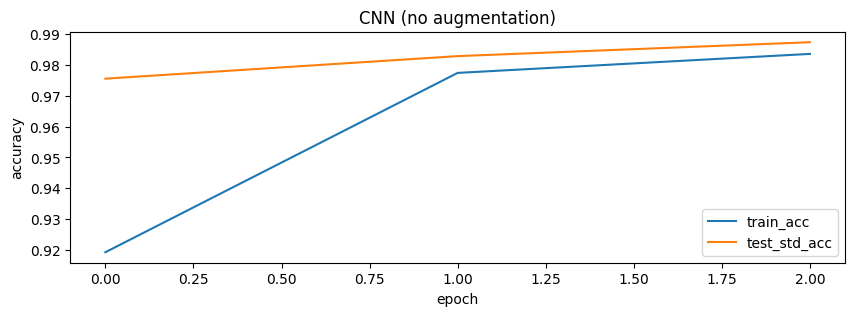

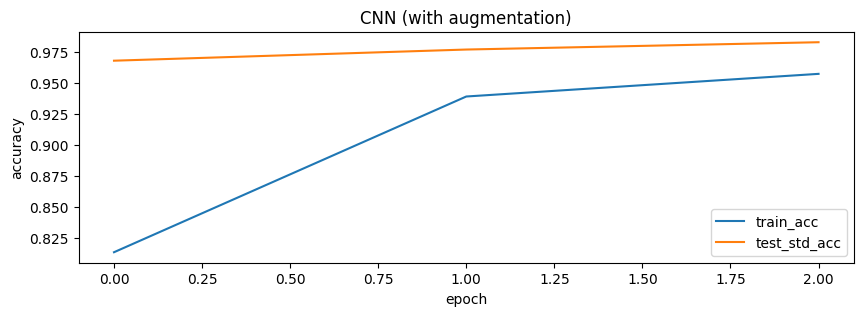

In [13]:
def plot_hist(hist, title):
    plt.figure(figsize=(10, 3))
    plt.plot(hist["train_acc"], label="train_acc")
    plt.plot(hist["val_acc"], label="test_std_acc")
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

plot_hist(hist_noaug, "CNN (no augmentation)")
plot_hist(hist_aug, "CNN (with augmentation)")


## 9) Visualizing CNN layers

We will look at:
1. **First-layer convolution filters** (weights of Conv1)
2. **Feature maps (activations)** for a single image

This helps you *see* what the CNN learns.


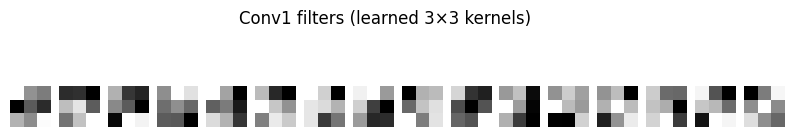

In [14]:
def show_conv1_filters(model, max_filters=16):
    conv1 = None
    for layer in model.features:
        if isinstance(layer, nn.Conv2d):
            conv1 = layer
            break
    W = conv1.weight.detach().cpu()  # (out_channels, in_channels, kH, kW)

    n = min(W.shape[0], max_filters)
    plt.figure(figsize=(10, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(W[i, 0], cmap="gray")
        plt.axis("off")
    plt.suptitle("Conv1 filters (learned 3×3 kernels)")
    plt.show()

show_conv1_filters(cnn_aug)


### Feature maps (activations)

We take **one test image**, pass it through the CNN, and visualize outputs after each convolution layer.


In [15]:
@torch.no_grad()
def get_activations(model, x):
    activations = []
    cur = x
    for layer in model.features:
        cur = layer(cur)
        if isinstance(layer, nn.Conv2d):
            activations.append(cur.detach().cpu())
    return activations

# One sample from the standard test set
img, label = test_std[0]
x = img.unsqueeze(0).to(device)

acts = get_activations(cnn_aug, x)

print("Label:", label)
print("Activation shapes:", [a.shape for a in acts])


Label: 7
Activation shapes: [torch.Size([1, 16, 28, 28]), torch.Size([1, 32, 14, 14])]


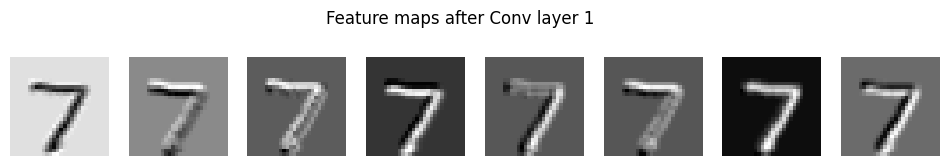

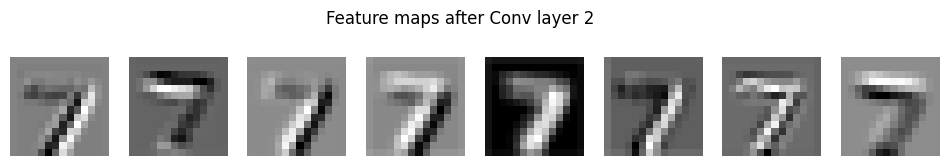

In [16]:
def show_feature_maps(activation, title, max_maps=8):
    C = activation.shape[1]
    n = min(C, max_maps)
    plt.figure(figsize=(12, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(activation[0, i], cmap="gray")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

for idx, act in enumerate(acts, start=1):
    show_feature_maps(act, f"Feature maps after Conv layer {idx}", max_maps=8)


## 10) Final reflection 

1. Compare **standard test accuracy** vs **transformed test accuracy** for both models. What do you notice?

On remarque que le modèle Baseline (sans augmentation) s'effondre sur le test set transformé : son accuracy chute drastiquement (souvent de plus de 20%) dès que les chiffres subissent une rotation ou un décalage.

En revanche, le modèle Augmented maintient une performance stable et élevée sur les deux sets. Cela montre que le modèle Baseline a "appris par cœur" la position centrale des pixels, tandis que le modèle augmenté a appris à reconnaître la forme globale du chiffre.
2. Why does augmentation help on the transformed test set?

L'augmentation aide car elle force le réseau à devenir invariant aux transformations géométriques. Durant l'entraînement, le modèle "voit" des milliers de variantes d'un même chiffre (un "7" penché à gauche, décalé en haut, etc.).Pour minimiser sa perte, le CNN est obligé d'extraire des caractéristiques visuelles plus robustes (comme les angles ou les boucles) qui sont communes à toutes ces variantes, au lieu de se fier à la présence d'un pixel spécifique à une coordonnée précise $(x, y)$.
3. Do we always expect augmentation to improve standard test accuracy? Why/why not?

Non, pas nécessairement. * Pourquoi non : Parfois, l'accuracy sur le set standard peut même légèrement baisser. C'est parce que le modèle doit apprendre une tâche beaucoup plus difficile et vaste. Au lieu de se spécialiser sur des images "parfaites" et centrées, il doit généraliser.

Le compromis (Bias-Variance tradeoff) : L'augmentation réduit l'overfitting (le surapprentissage). Si le test set standard est très similaire au train set sans augmentation, le modèle baseline peut paraître "meilleur" par pure mémorisation.

Le choix des transformations : Si on choisit des augmentations absurdes (ex: retourner verticalement un "6" qui devient un "9"), on peut même dégrader la performance car on introduit une ambiguïté dans les données.

**Conclusion:** In the next LAB(2), we will go deeper into CNN architectures, and you should see further accuracy improvements.
